# Lab 3: CNNs and Deep Learning

### Sridhar Adhikarla (sriad858), Naveen Gabriel (navga709)

## TBMI26/732A55 Neural Networks and Learning Systems

### Michael Felsberg

## 2D Convolution
For the further steps, we often need to visualize an image and we define a shortcut for that:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

def visualize(img):
    plt.imshow(img,'gray')
    plt.colorbar()
    plt.show()
    print('Image size:', img.shape)

Convolution can be performed in 2D using the function `scipy.signal.convolve2d()`.  

**Task 1:** Use this function to generate a 2D kernel of size $33\times33$ by five times cascading 2D convolutions of $h$ with itself, starting with $h = \begin{array}{|c|c|}
      \hline
      \frac{1}{4} & \frac{1}{4} \\
      \hline
      \frac{1}{4} & \frac{1}{4} \\
      \hline
    \end{array}$. Visualize the kernel.

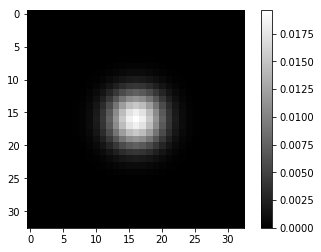

Image size: (33, 33)


In [2]:
 from scipy import signal
 import numpy as np
 
 res =np.matrix([[1/4,1/4],[1/4,1/4]])
 for i in range(0,5):  
        res = signal.convolve2d(res,res,mode="full")

 visualize(res)
 


**Task 2:** Now, load the image 'MR15^044.JPG' (a sample from ImageNet), convert it to gray-scale by summing its  R-, G-, and B-values at each pixel, and normalize it to the interval $[0;1]$. Convolve it with $h$ from the previous task with the options `'valid'` and `'same'`. Visualize all three images. What differences do you observe regarding the size and intensity of the output?

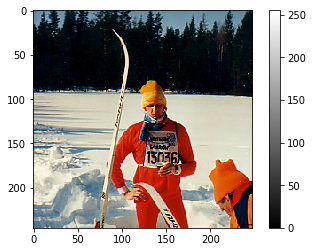

Image size: (246, 248, 3)
The original image


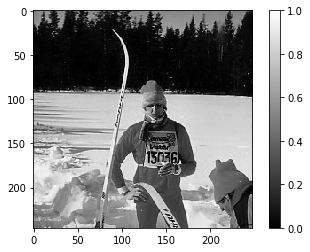

Image size: (246, 248)
The gray scale image


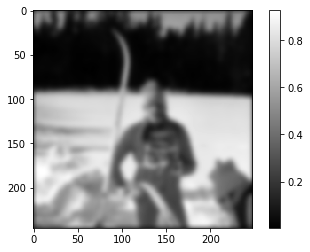

Image size: (246, 248)
Convolved image with mode as 'same'


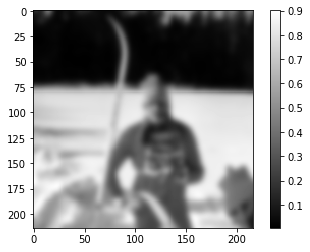

Image size: (214, 216)
Convolved image with mode as 'valid'


"The normal image is normalized to grayscale image by reducing the rgb dimension to 1.The grey scale image has same dimension as off original image but it is less intense.The gray scale image is convolved with mode 'valid' has lesser dimension than the orginal and with mode 'same' which has same dimension as the original image. Convolved image with mode 'valid' is least intense."

In [3]:
import matplotlib.image as img

img=img.imread('../input/MR15044.JPG')
dim = img.shape

visualize(img)
print("The original image")

img_new = np.zeros((dim[0],dim[1]))    # img_new would be our normalized image

for i in range(0,246):
    for j in range(0,248):
        for z in range(0,3):
            img_new[i,j] = img[i,j,z] + img_new[i,j]      # reducing the three dimension into 1
 
img_new=img_new/255   

maxi = np.amax(img_new)
mini = np.amin(img_new)
diff = maxi - mini

for i in range(0,246):
    for j in range(0,248):
        img_new[i,j]=(img_new[i,j]-mini)/diff     #normalizing the image

#img_n = img.sum(axis=2)
visualize(img_new)
print("The gray scale image")

img1_old = signal.convolve2d(img_new,res,mode="same")
img2_old = signal.convolve2d(img_new,res,mode="valid")

visualize(img1_old)
print("Convolved image with mode as 'same'")


visualize(img2_old)
print("Convolved image with mode as 'valid'")

'''The normal image is normalized to grayscale image by reducing the rgb dimension to 1.\
The grey scale image has same dimension as off original image but it is less intense.\
The gray scale image is convolved with mode 'valid' has lesser dimension than the orginal \
and with mode 'same' which has same dimension as the original image. Convolved image with \
mode 'valid' is least intense.'''

Strided convolution removes samples. According to the Nyquist theorem, this can generate aliasing artifacts.  

**Task 3:** Visualize the original gray-scale image and the output image from the previous task (with option `'same'`) with only keping every fifth row and column (stride 5). What do you observe, in particular at the ski?

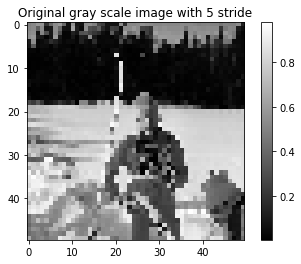

Image size: (50, 50)


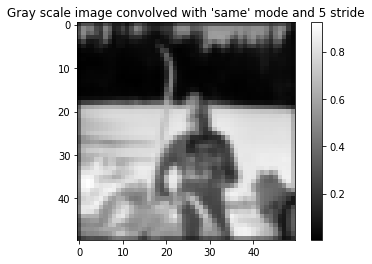

Image size: (50, 50)


'The image is ski is distorted more in the original image with stride 5 than in the\nconvoluted image. The boundaries of ski is much more visible in convolved image thanin the orginal gray scale image with stride 5'

In [4]:
import math as mth

img_new1 = signal.convolve2d(img_new,res,mode="same")
d = img_new1.shape
d_f = res.shape

#n_r = mth.floor(1+(d[0] - d_f[0])/5)
#n_c = mth.floor(1+(d[1] - d_f[1])/5)

img_str_convolv = img_new1[::5,::5]
img_str = img_new[::5,::5]

#Below code giving slight miscalculation error which is not same as one liner
# img_str_convolv= np.zeros((50,50)) #new image with dimension
# img_str= np.zeros((50,50))


# for i in range(0,d[0]):
#     for j in range(0,d[1]):
#         if(i%5==0 and (i+d_f[0])<d[0]):
#             if(j%5==0 and (j+d_f[1])<d[1]):
#                 k=int(j/5)
#                 z=int(i/5)
#                 img_str_convolv[z,k]=img_new1[i,j]
#                 img_str[z,k] = img_new[i,j]
                

plt.title("Original gray scale image with 5 stride")    
visualize(img_str)

plt.title("Gray scale image convolved with 'same' mode and 5 stride")
visualize(img_str_convolv)



'''The image is ski is distorted more in the original image with stride 5 than in the
convoluted image. The boundaries of ski is much more visible in convolved image than\
in the orginal gray scale image with stride 5'''

## Convolution  in TensorFlow
We will now repeat the same steps in TensorFlow, where we will exploit its capability to perform *eager execution*. This is initialized as follows:

In [5]:
import tensorflow as tf

print('TensorFlow version '+tf.__version__)
tf.enable_eager_execution()
if tf.executing_eagerly():
    print('Eager execution activated!')

TensorFlow version 1.13.1
Eager execution activated!


TensorFlow allows to map from and to numpy. Also, operations are automatically casted. In order to get used to TensorFlow and the casting, we repeat the convolution 1.a) from class 5 (see Lisam). As you have learned in the lecture, any convolution with kernel $h$ can also be performed as matrix multiplication by the Toeplitz matrix $H$.

**Task 4:**  Use `scipy.linalg.toeplitz` to generate the matrix $H$ for the kernel $h= \begin{array}{|c|c|c|}
      \hline
      \hphantom{-}1 & \hphantom{-}\textbf{2} & -2 \\
      \hline
    \end{array}$ and boundary condition `'same'` and $f= \begin{array}{|c|c|c|c|c|c|c|c|}
      \hline
      \hphantom{-}1 & -1 & -2 & \hphantom{-}\textbf{0} & -1 & \hphantom{-}1 & \hphantom{-}2 & -1 \\
      \hline
    \end{array}$ in TensorFlow (`tf.constant()`). Multiply $H$ and $f$ and display the result. Verify that the result is the same as in 1.a). What are the respective classes of $H$, $f$, and the result?  
    Hints: `scipy.linalg.toeplitz` can take the first column and row as input; `[*np.zeros()]=np.zeros()` (`*` dereferences all elements of a tuple) 

In [6]:
from scipy import linalg

f = tf.constant([1, -1, -2, 0, -1, 1, 2,-1],shape=(8,1))
h = tf.constant([-2,2,1])

pad = np.zeros(6,dtype=int)
row = np.r_[h[1:],pad]


col = np.r_[[2,-2],pad]

tp=linalg.toeplitz(col,row)

tp = tf.constant(tp,dtype=tf.int32)

print("Toeplitz matrix:\n",tp)

print("\n\nThe convoluted array which is of same size is:\n",tp @ f)

print("\n\nH is:\n",h)

print("\n\nf is:\n",f)


Toeplitz matrix:
 tf.Tensor(
[[ 2  1  0  0  0  0  0  0]
 [-2  2  1  0  0  0  0  0]
 [ 0 -2  2  1  0  0  0  0]
 [ 0  0 -2  2  1  0  0  0]
 [ 0  0  0 -2  2  1  0  0]
 [ 0  0  0  0 -2  2  1  0]
 [ 0  0  0  0  0 -2  2  1]
 [ 0  0  0  0  0  0 -2  2]], shape=(8, 8), dtype=int32)


The convoluted array which is of same size is:
 tf.Tensor(
[[ 1]
 [-6]
 [-2]
 [ 3]
 [-1]
 [ 6]
 [ 1]
 [-6]], shape=(8, 1), dtype=int32)


H is:
 tf.Tensor([-2  2  1], shape=(3,), dtype=int32)


f is:
 tf.Tensor(
[[ 1]
 [-1]
 [-2]
 [ 0]
 [-1]
 [ 1]
 [ 2]
 [-1]], shape=(8, 1), dtype=int32)


Keras layers can be applied in eager mode using the `tf.keras.layers` package. **NOTE:**  `tf.keras.layers` and **NOT** `keras.layers`.

**Task 5:** Perform the convolution from the previous task using a convolution layer `Conv1D` and a (trivial) `Sequential` model from `tf.keras`.  
Hints: RTFM of `tf.keras.Sequential` - weights can be set for the model (list) or the layer (by traversing the layers list). Apply `use_bias=False` to avoid random DC-shifts.

In [7]:
import tensorflow as tf
#Since tensor flow use graph model, it uses sequential to stack up layers 
#Between those layers tensor flows
from tensorflow.keras import Sequential  

#To build a convolution 1D model
from tensorflow.keras.layers import Conv1D

mdl = Sequential()


#kernelsize is length of kernel
#filters is dimensionality of outer space. We know prior that dimension of our output is 1D
#input_shape accepts the input shape of the layer,
mdl.add(Conv1D(kernel_size=3,filters = 1,
                   strides=1,padding="same",input_shape = (8,1),
                   use_bias= False))

h = tf.constant([-2, 2, 1], shape=(1,3,1,1))

#print(h.shape)
#setting the weights
#bb = mdl.get_weights()

mdl.set_weights(h) 

#If dtype float is ommitted, it throws some error. The shape of input, it expects type of float.
#Don't know why?
z = tf.constant([1, -1, -2, 0, -1, 1, 2,-1], shape=(1,8,1),dtype= tf.float32)

mdl(z)

Instructions for updating:
Colocations handled automatically by placer.


<tf.Tensor: id=67, shape=(1, 8, 1), dtype=float32, numpy=
array([[[ 1.],
        [-6.],
        [-2.],
        [ 3.],
        [-1.],
        [ 6.],
        [ 1.],
        [-6.]]], dtype=float32)>

**Task 6:** Apply the cascaded $33\times33$ filter from task 1 to the image from task 2 using a `Conv2D` layer. Compare the result visually and by subtracting the fitting result from task 2.

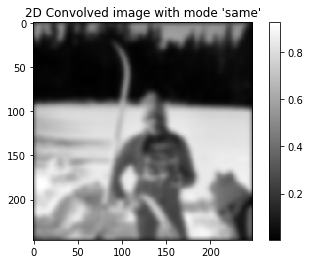

Image size: (246, 248)


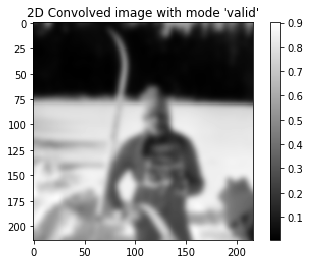

Image size: (214, 216)
Sum of differences of pixel for convoluted image with mode 'same': 0.0127500035
Sum of differences of pixel for convoluted image with mode 'valid': 0.00047957432


'The difference seems to be small and by visually checking the convolved image from this output to the output from task 2 , both looks more or less same.'

In [8]:
from tensorflow.keras.layers import Conv2D

model_img = Sequential()   #for same mode
model_img2 = Sequential()  #for valid mode

#kernelsize is dimension of kernel
#filters is dimensionality of output space. We know prior that dimension of our output is 2D
#input_shape accepts the input shape of the layer, the third parameter is 1 because we had normalized 
#the image

model_img.add(Conv2D(filters = 1 ,kernel_size=(33,33),
                              padding="same",
                              input_shape = (246,248,1),
                              use_bias=False))

model_img2.add(Conv2D(filters = 1 ,kernel_size=(33,33),
                              padding="valid",
                              input_shape = (246,248,1),
                              use_bias=False))

new_kern = tf.constant(res,shape=(1,33,33,1,1))     
img_new2 = tf.constant(img_new,shape= (1,246,248,1),dtype=tf.float32)  #orginal gray scale image with differen shape dimension

model_img.set_weights(new_kern)
model_img2.set_weights(new_kern)

img1 = model_img(img_new2)
img2 = model_img2(img_new2)

img1 = tf.reshape(img1,(246,248))
img2 = tf.reshape(img2,(214,216))

batch = img_new2  
label = img1

plt.title("2D Convolved image with mode 'same'")
visualize(img1)

plt.title("2D Convolved image with mode 'valid'")
visualize(img2)


print("Sum of differences of pixel for convoluted image with mode 'same':",np.sum(img1_old-img1))
print("Sum of differences of pixel for convoluted image with mode 'valid':",np.sum(img2_old-img2))


'''The difference seems to be small and by visually checking the convolved image from this output \
to the output from task 2 , both looks more or less same.'''

**Task 7:** Repeat the previous task with stride 5 and compare the result visually and by subtracting the fitting result from task 3. Repeat the task, but with a $1\times1$ filter (coefficient `1`) and stride 5. Compare again the result visually and by subtracting the fitting result from task 3.  
Hint: You might need to adjust the offset for the subsampling.

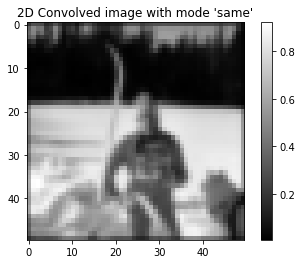

Image size: (50, 50)


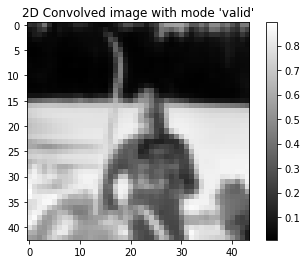

Image size: (43, 44)
Sum of differences of pixel for convoluted image with
mode 'same' and 5 strides: 0.44529063


In [9]:
model1_img = Sequential()    #for same mode with stride 5
model1_img2 = Sequential()   #for valid mode with stride 5


model1_img.add(Conv2D(filters = 1 ,kernel_size=(33,33),
                              padding="same", strides= 5,
                              input_shape = (246,248,1),
                              use_bias=False))

model1_img2.add(Conv2D(filters = 1 ,kernel_size=(33,33),
                              padding="valid", strides=5,
                              input_shape = (246,248,1),
                              use_bias=False))

# new_kern = tf.constant(res,shape=(1,33,33,1,1))
# img_new2 = tf.constant(img_new,shape= (1,246,248,1),dtype=tf.float32)

model1_img.set_weights(new_kern)
model1_img2.set_weights(new_kern)

img_1 = model1_img(img_new2)
img_2 = model1_img2(img_new2)

img_1 = tf.reshape(img_1,(50,50))
img_2 = tf.reshape(img_2,(43,44))

plt.title("2D Convolved image with mode 'same'")
visualize(img_1)

plt.title("2D Convolved image with mode 'valid'")
visualize(img_2)

print("Sum of differences of pixel for convoluted image with\nmode 'same' and 5 strides:",np.sum(img_1-img_str_convolv))


Repeating the above task with  filter 1 and stride 5


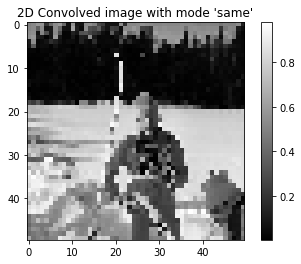

Image size: (50, 50)


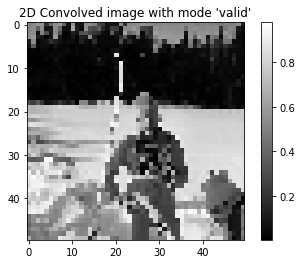

Image size: (50, 50)
Sum of differences of pixel for convoluted image with
mode 'same' and 1 strides: 0.0


In [10]:
print("Repeating the above task with  filter 1 and stride 5")

model2_img = Sequential()
model2_img2 = Sequential()


model2_img.add(Conv2D(filters = 1 ,kernel_size=(1,1),
                              padding="same", strides= 5,
                              input_shape = (246,248,1),
                              use_bias=False))

model2_img2.add(Conv2D(filters = 1 ,kernel_size=(1,1),
                              padding="valid", strides=5,
                              input_shape = (246,248,1),
                              use_bias=False))

new_kern = tf.constant([np.array([1]).reshape((1, 1, 1 ,1))])
img_new2 = tf.constant(img_new,shape= (1,246,248,1),dtype=tf.float32)

model2_img.set_weights(new_kern)
model2_img2.set_weights(new_kern)

img1_n = model2_img(img_new2)
img2_n = model2_img2(img_new2)

img1_n = tf.reshape(img1_n,(50,50))
img2_n = tf.reshape(img2_n,(50,50))

plt.title("2D Convolved image with mode 'same'")
visualize(img1_n)

plt.title("2D Convolved image with mode 'valid'")
visualize(img2_n)



print("Sum of differences of pixel for convoluted image with\nmode 'same' and 1 strides:",np.sum(img1_n-img_str))


We now define a new filter that is, unlike $h$, anti-symmetric:

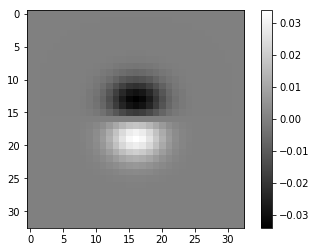

Image size: (33, 33)


In [11]:
fsz = 33
hfsz = 17
res_n= tf.cast(res,np.float32)
g = res_n*(np.expand_dims(np.arange(-hfsz+1,hfsz),1)@np.ones((1,fsz)))

visualize(g)


**Task 8:** repeat tasks 6 & 7 with $g$ instead of $h$. What difference do you observe and why?

For task 6




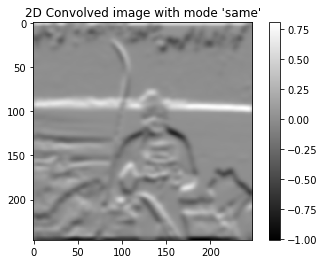

Image size: (246, 248)


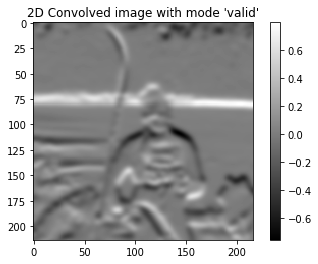

Image size: (214, 216)
Sum of differences of pixel for convoluted image with mode 'same': 25409.67
Sum of differences of pixel for convoluted image with mode 'valid': 18940.45


In [12]:
print("For task 6\n\n")

model_img = Sequential()
model_img2 = Sequential()

model_img.add(Conv2D(filters = 1 ,kernel_size=(33,33),
                              padding="same",
                              input_shape = (246,248,1),
                              use_bias=False))

model_img2.add(Conv2D(filters = 1 ,kernel_size=(33,33),
                              padding="valid",
                              input_shape = (246,248,1),
                              use_bias=False))

new_kern = tf.constant(g,shape=(1,33,33,1,1))

img_new2 = tf.constant(img_new,shape= (1,246,248,1),dtype=tf.float32)

model_img.set_weights(new_kern)
model_img2.set_weights(new_kern)

img1 = model_img(img_new2)
img2 = model_img2(img_new2)

img1 = tf.reshape(img1,(246,248))
img2 = tf.reshape(img2,(214,216))

plt.title("2D Convolved image with mode 'same'")
visualize(img1)

plt.title("2D Convolved image with mode 'valid'")
visualize(img2)

#Need to check the subtraction

print("Sum of differences of pixel for convoluted image with mode 'same':",np.sum(img1_old-img1))
print("Sum of differences of pixel for convoluted image with mode 'valid':",np.sum(img2_old-img2))
#print(img1_comp.shape)

For task 7




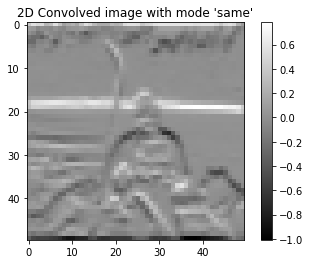

Image size: (50, 50)


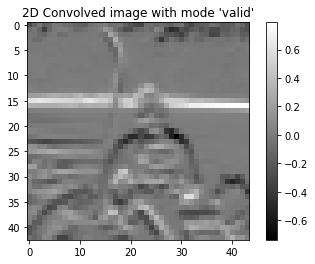

Image size: (43, 44)
Sum of differences of pixel for convoluted image with
mode 'same' and 5 strides: -1032.6494


'For both task 6 and 7 , we get the images with boundary and lines. The new kernel\\ is anti symmetric and sum of its value is zero. So there are equivalent number of same +ve and -ve value in the kernel.  When we do convolution with this kernel,the image pixels which are nearly same gets canceled out hence  producing the similar output. That is what happening in area of snow and forest. At boundary the pixel values of two object changes. Hence the convolved image at the boundary has different pixels values.'

In [13]:
print("For task 7\n\n")

model1_img = Sequential()
model1_img2 = Sequential()


model1_img.add(Conv2D(filters = 1 ,kernel_size=(33,33),
                              padding="same", strides= 5,
                              input_shape = (246,248,1),
                              use_bias=False))

model1_img2.add(Conv2D(filters = 1 ,kernel_size=(33,33),
                              padding="valid", strides=5,
                              input_shape = (246,248,1),
                              use_bias=False))

new_kern = tf.constant(g,shape=(1,33,33,1,1))
img_new2 = tf.constant(img_new,shape= (1,246,248,1),dtype=tf.float32)

model1_img.set_weights(new_kern)
model1_img2.set_weights(new_kern)

img_1 = model1_img(img_new2)
img_2 = model1_img2(img_new2)

img_1 = tf.reshape(img_1,(50,50))
img_2 = tf.reshape(img_2,(43,44))

plt.title("2D Convolved image with mode 'same'")
visualize(img_1)

plt.title("2D Convolved image with mode 'valid'")
visualize(img_2)


print("Sum of differences of pixel for convoluted image with\nmode 'same' and 5 strides:",np.sum(img_1-img_str_convolv))

'''For both task 6 and 7 , we get the images with boundary and lines. The new kernel\ is anti symmetric\
 and sum of its value is zero. So there are equivalent number of same +ve and -ve value in the kernel.\
  When we do convolution with this kernel,the image pixels which are nearly same gets canceled out hence\
  producing the similar output. That is what happening in area of snow and forest. At boundary the\
 pixel values of two object changes. Hence the convolved image at the boundary has different pixels\
 values.'''

## Training layers
We now take the input and output from task 6 as training data (input and output) for supervised learning of a convolution layer.  
**Task 9:** Although we only have a single input and output image, we can expect the training to work, although this usually requires multiple samples. Why? Define two tensors `batch` and `label` that contain the data from task 6.

In [14]:
# batch = img_new2  
# label = img1

label = tf.reshape(label, shape=(1,246,248,1))

**Task 10:** We want to apply the L1-loss. Define a suitable function `loss(model, x, y)` that can be used during training.

In [15]:
def  loss(model,x,y):
    pred = model(x)
    return(tf.reduce_mean(tf.abs(y-pred)))

Training a layers requires computing the gradient. For TF in eager mode, we use `GradientTape()` for this purpose.  
**Task 11:** Train the model from task 6 (but without assigning the weights) using the data from task 9, the loss from task 10, and `GradientDescentOptimizer()`. During training, print the loss every 100 steps and visualize the learned kernel after training.  
Hint: add a kernel_constraint to be non-negative.

In [16]:
    model = Sequential()
    
    model.add(Conv2D(filters = 1 ,kernel_size=(33,33),
                              padding="same",
                              input_shape = (246,248,1),
                              use_bias=False,
                              kernel_constraint= tf.keras.constraints.NonNeg()))
    
    
    train = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
    
    itertns = 3000
    
    for i in range(itertns) :
        with tf.GradientTape() as t:
            val = loss(model,batch,label)
            d_w = t.gradient(val, model.variables)  
            train.apply_gradients(zip(d_w,model.variables))
            
            if (i) % 100 == 0:
                print("Iteration - {0} | Loss :{1}".format(i,val.numpy()))
                
        learnd_kern = model.get_weights()

Iteration - 0 | Loss :0.1667262464761734
Iteration - 100 | Loss :4.452737808227539
Iteration - 200 | Loss :3.716785192489624
Iteration - 300 | Loss :3.039980888366699
Iteration - 400 | Loss :2.4179935455322266
Iteration - 500 | Loss :1.8618255853652954
Iteration - 600 | Loss :1.3667666912078857
Iteration - 700 | Loss :0.9267941117286682
Iteration - 800 | Loss :0.5469374656677246
Iteration - 900 | Loss :0.24121230840682983
Iteration - 1000 | Loss :0.09999390691518784
Iteration - 1100 | Loss :0.086723692715168
Iteration - 1200 | Loss :0.08091440051794052
Iteration - 1300 | Loss :0.0752488225698471
Iteration - 1400 | Loss :0.06975623965263367
Iteration - 1500 | Loss :0.06445590406656265
Iteration - 1600 | Loss :0.059286877512931824
Iteration - 1700 | Loss :0.054275475442409515
Iteration - 1800 | Loss :0.049426108598709106
Iteration - 1900 | Loss :0.04480786994099617
Iteration - 2000 | Loss :0.04046047851443291
Iteration - 2100 | Loss :0.03626858443021774
Iteration - 2200 | Loss :0.0322891

Trained kernel


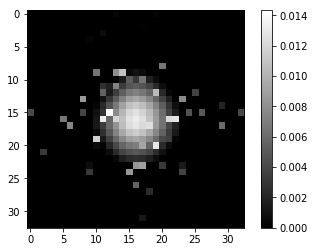

Image size: (33, 33)


In [17]:
    print("Trained kernel")
    visualize(learnd_kern[0].reshape(33,33))
    

The result can be improved in several ways: data augmentation (e.g. by flipping the image, using the three RGB-channel separately), regularizing the weights (e.g. using the L1-norm), and replacing the optimizer (e.g., ADAM).  
**Extra task (not to be done before task 14 is completed):** Try to improve the result using one or several of the mentioned approaches.